In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pandas_datareader.data as web
from time import time
from scipy.stats import zscore
from sklearn.cluster import KMeans

In [348]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [349]:
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data

In [350]:
X1.describe()

Attributes    Adj Close             
Symbols           GOOGL          IBM
count       1258.000000  1258.000000
mean          83.566410   115.528194
std           31.504997    10.843052
min           48.339001    79.847008
25%           57.260624   109.069324
50%           69.874500   114.224731
75%          112.697622   124.163900
max          149.838501   141.102219

In [351]:
X2.describe()

,DEXJPUS,DEXUSUK
count,1240.000000,1240.000000
mean,111.983468,1.310116
std,7.951079,0.060000
min,102.520000,1.092100
25%,107.697500,1.272050
50%,109.805000,1.310500
75%,112.805000,1.356225
max,144.390000,1.433200


In [352]:
X3.describe()

,SP500,DJIA,VIXCLS
count,1257.000000,1257.000000,1260.000000
mean,3388.606508,28622.941702,20.611071
std,685.678284,4099.333444,8.679978
min,2237.400000,18591.930000,9.140000
25%,2798.430000,25333.820000,14.747500
50%,3130.120000,27173.960000,18.840000
75%,4019.870000,32654.590000,24.645000
max,4796.560000,36799.650000,82.690000


In [353]:
X1.fillna(X1.median(),inplace = True)
X2.fillna(X2.median(),inplace = True)
X3.fillna(X3.median(),inplace = True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9856\15481099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1.fillna(X1.median(),inplace = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9856\15481099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1.fillna(X1.median(),inplace = True)


In [354]:
scaler = preprocessing.StandardScaler()
X1 = pd.DataFrame(scaler.fit_transform(X1.values),index = X1.index,columns=X1.columns)
X2 = pd.DataFrame(scaler.fit_transform(X2.values),index = X2.index,columns=X2.columns)
X3 = pd.DataFrame(scaler.fit_transform(X3.values),index = X3.index,columns=X3.columns)

In [355]:
X1

Attributes Adj Close          
Symbols        GOOGL       IBM
Date                          
2017-10-03 -1.110183 -0.452097
2017-10-04 -1.118598 -0.472958
2017-10-05 -1.089369 -0.456268
2017-10-06 -1.075953 -0.472958
2017-10-09 -1.078064 -0.409680
...              ...       ...
2022-09-26  0.463717  0.598022
2022-09-27  0.442442  0.573111
2022-09-28  0.523414  0.667218
2022-09-29  0.439902  0.562962
2022-09-30  0.383698  0.302785

[1258 rows x 2 columns]

In [356]:
X2

,DEXJPUS,DEXUSUK
DATE,,
2017-10-04,0.122586,0.284319
2017-10-05,0.109734,0.052318
2017-10-06,0.102023,-0.065389
2017-10-09,-0.267452,0.006258
2017-10-10,0.033911,0.193907
...,...,...
2022-09-19,4.042239,-2.897174
2022-09-20,4.080793,-2.893762
2022-09-21,4.145050,-3.021704


In [357]:
X3

,SP500,DJIA,VIXCLS
DATE,,,
2017-10-04,-1.247234,-1.465231,-1.279291
2017-10-05,-1.226001,-1.437030,-1.330825
2017-10-06,-1.230061,-1.437457,-1.276949
2017-10-09,-1.236877,-1.440580,-1.197305
2017-10-10,-1.228120,-1.423323,-1.226586
...,...,...,...
2022-09-26,0.408304,0.170821,1.371203
2022-09-27,0.396821,0.139628,1.411025
2022-09-28,0.503135,0.275673,1.127588


In [358]:
Y = pd.DataFrame()
return_period = 1
backHistory = [30, 45, 60, 90, 180, 240]
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]
Y = base.shift(-return_period)
X4_BH1 = base.diff( BH1).shift( - BH1)
X4_BH2 = base.diff( BH2).shift( - BH2)
X4_BH3 = base.diff( BH3).shift( - BH3)

X4 = pd.concat([X4_BH1, X4_BH2, X4_BH3], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [359]:
Y

Date
2017-10-03     70.182434
2017-10-04     71.385201
2017-10-05     71.413376
2017-10-06     71.685860
2017-10-09     71.685860
                 ...    
2022-09-26    236.410004
2022-09-27    241.070007
2022-09-28    237.500000
2022-09-29    232.899994
2022-09-30           NaN
Name: (Adj Close, MSFT), Length: 1258, dtype: float64

In [360]:
X4

,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,
2017-10-03,0.079277,0.011765,-0.147903
2017-10-04,0.040651,0.022152,-0.178815
2017-10-05,0.061980,0.027228,-0.266734
2017-10-06,0.117952,0.097032,-0.249042
2017-10-09,0.121259,0.060710,-0.297954
...,...,...,...
2022-09-26,NaN,NaN,NaN
2022-09-27,NaN,NaN,NaN
2022-09-28,NaN,NaN,NaN


In [361]:
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)

In [362]:
X

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-03,-1.110183,-0.452097,NaN,NaN,NaN,NaN,NaN,0.079277,0.011765,-0.147903
2017-10-04,-1.118598,-0.472958,0.122586,0.284319,-1.247234,-1.465231,-1.279291,0.040651,0.022152,-0.178815
2017-10-05,-1.089369,-0.456268,0.109734,0.052318,-1.226001,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2017-10-06,-1.075953,-0.472958,0.102023,-0.065389,-1.230061,-1.437457,-1.276949,0.117952,0.097032,-0.249042
2017-10-09,-1.078064,-0.409680,-0.267452,0.006258,-1.236877,-1.440580,-1.197305,0.121259,0.060710,-0.297954
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.463717,0.598022,NaN,NaN,0.408304,0.170821,1.371203,NaN,NaN,NaN
2022-09-27,0.442442,0.573111,NaN,NaN,0.396821,0.139628,1.411025,NaN,NaN,NaN
2022-09-28,0.523414,0.667218,NaN,NaN,0.503135,0.275673,1.127588,NaN,NaN,NaN
2022-09-29,0.439902,0.562962,NaN,NaN,0.386715,0.162094,1.322012,NaN,NaN,NaN


In [363]:
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-03,70.182434,-1.110183,-0.452097,NaN,NaN,NaN,NaN,NaN,0.079277,0.011765,-0.147903
2017-10-04,71.385201,-1.118598,-0.472958,0.122586,0.284319,-1.247234,-1.465231,-1.279291,0.040651,0.022152,-0.178815
2017-10-05,71.413376,-1.089369,-0.456268,0.109734,0.052318,-1.226001,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2017-10-06,71.685860,-1.075953,-0.472958,0.102023,-0.065389,-1.230061,-1.437457,-1.276949,0.117952,0.097032,-0.249042
2017-10-09,71.685860,-1.078064,-0.409680,-0.267452,0.006258,-1.236877,-1.440580,-1.197305,0.121259,0.060710,-0.297954
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,236.410004,0.463717,0.598022,NaN,NaN,0.408304,0.170821,1.371203,NaN,NaN,NaN
2022-09-27,241.070007,0.442442,0.573111,NaN,NaN,0.396821,0.139628,1.411025,NaN,NaN,NaN
2022-09-28,237.500000,0.523414,0.667218,NaN,NaN,0.503135,0.275673,1.127588,NaN,NaN,NaN
2022-09-29,232.899994,0.439902,0.562962,NaN,NaN,0.386715,0.162094,1.322012,NaN,NaN,NaN


In [364]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2017-10-03 to 2022-09-30
Freq: B
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1257 non-null   float64
 1   (Adj Close, GOOGL)  1258 non-null   float64
 2   (Adj Close, IBM)    1258 non-null   float64
 3   DEXJPUS             1298 non-null   float64
 4   DEXUSUK             1298 non-null   float64
 5   SP500               1303 non-null   float64
 6   DJIA                1303 non-null   float64
 7   VIXCLS              1303 non-null   float64
 8   MSFT_3DT            1213 non-null   float64
 9   MSFT_6DT            1168 non-null   float64
 10  MSFT_12DT           1078 non-null   float64
dtypes: float64(11)
memory usage: 122.2 KB


In [365]:
dataset=dataset.dropna()

In [366]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1077 entries, 2017-10-04 to 2022-01-12
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1077 non-null   float64
 1   (Adj Close, GOOGL)  1077 non-null   float64
 2   (Adj Close, IBM)    1077 non-null   float64
 3   DEXJPUS             1077 non-null   float64
 4   DEXUSUK             1077 non-null   float64
 5   SP500               1077 non-null   float64
 6   DJIA                1077 non-null   float64
 7   VIXCLS              1077 non-null   float64
 8   MSFT_3DT            1077 non-null   float64
 9   MSFT_6DT            1077 non-null   float64
 10  MSFT_12DT           1077 non-null   float64
dtypes: float64(11)
memory usage: 101.0 KB


In [367]:
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-04,71.385201,-1.118598,-0.472958,0.122586,0.284319,-1.247234,-1.465231,-1.279291,0.040651,0.022152,-0.178815
2017-10-05,71.413376,-1.089369,-0.456268,0.109734,0.052318,-1.226001,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2017-10-06,71.685860,-1.075953,-0.472958,0.102023,-0.065389,-1.230061,-1.437457,-1.276949,0.117952,0.097032,-0.249042
2017-10-09,71.685860,-1.078064,-0.409680,-0.267452,0.006258,-1.236877,-1.440580,-1.197305,0.121259,0.060710,-0.297954
2017-10-10,71.808052,-1.085225,-0.332492,0.033911,0.193907,-1.228120,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06,312.001495,1.720446,1.379700,0.500415,0.746617,1.950801,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
2022-01-07,312.230011,1.697250,1.334335,0.478567,0.821676,1.922619,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
2022-01-10,312.935425,1.749722,1.352124,0.418166,0.794382,1.912632,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
2022-01-11,316.204041,1.783588,1.159993,0.449009,0.888206,1.976020,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [368]:
ying = dataset.columns[0]
dataset = dataset.drop(dataset.columns[0],axis = 1)

In [369]:
dataset

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-04,-1.118598,-0.472958,0.122586,0.284319,-1.247234,-1.465231,-1.279291,0.040651,0.022152,-0.178815
2017-10-05,-1.089369,-0.456268,0.109734,0.052318,-1.226001,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2017-10-06,-1.075953,-0.472958,0.102023,-0.065389,-1.230061,-1.437457,-1.276949,0.117952,0.097032,-0.249042
2017-10-09,-1.078064,-0.409680,-0.267452,0.006258,-1.236877,-1.440580,-1.197305,0.121259,0.060710,-0.297954
2017-10-10,-1.085225,-0.332492,0.033911,0.193907,-1.228120,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...,...,...
2022-01-06,1.720446,1.379700,0.500415,0.746617,1.950801,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
2022-01-07,1.697250,1.334335,0.478567,0.821676,1.922619,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
2022-01-10,1.749722,1.352124,0.418166,0.794382,1.912632,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
2022-01-11,1.783588,1.159993,0.449009,0.888206,1.976020,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [370]:
data = dataset.corr()
data

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
"(Adj Close, GOOGL)",1.000000,0.498602,0.125983,0.484628,0.982965,0.953698,0.038876,0.000742,-0.109717,-0.400642
"(Adj Close, IBM)",0.498602,1.000000,0.253159,0.585135,0.518935,0.599503,-0.531373,-0.030430,-0.088635,-0.395574
DEXJPUS,0.125983,0.253159,1.000000,0.082689,0.047833,0.093279,-0.396705,-0.304603,-0.447009,-0.584303
DEXUSUK,0.484628,0.585135,0.082689,1.000000,0.487733,0.531688,-0.301577,0.052835,0.012583,-0.203331
SP500,0.982965,0.518935,0.047833,0.487733,1.000000,0.983451,-0.006288,-0.029528,-0.089046,-0.315847
DJIA,0.953698,0.599503,0.093279,0.531688,0.983451,1.000000,-0.135397,-0.045015,-0.081379,-0.305023
VIXCLS,0.038876,-0.531373,-0.396705,-0.301577,-0.006288,-0.135397,1.000000,0.278414,0.328029,0.252611
MSFT_3DT,0.000742,-0.030430,-0.304603,0.052835,-0.029528,-0.045015,0.278414,1.000000,0.669665,0.418242
MSFT_6DT,-0.109717,-0.088635,-0.447009,0.012583,-0.089046,-0.081379,0.328029,0.669665,1.000000,0.693987
MSFT_12DT,-0.400642,-0.395574,-0.584303,-0.203331,-0.315847,-0.305023,0.252611,0.418242,0.693987,1.000000


<AxesSubplot:>

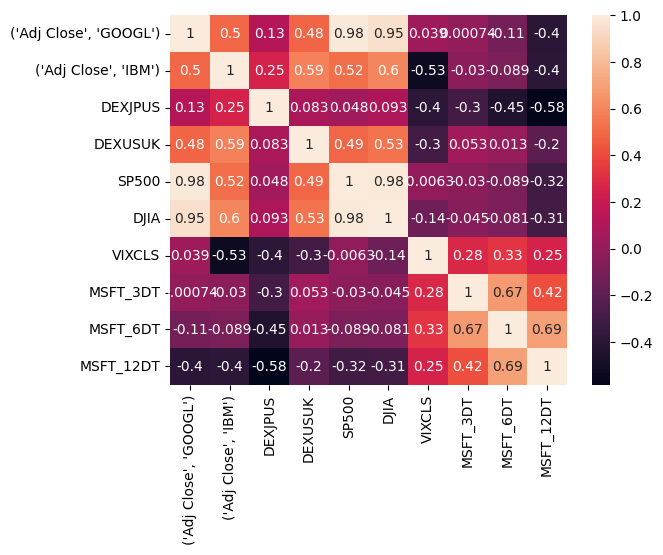

In [371]:
sns.heatmap(data,annot=True)

In [372]:
lower = pd.DataFrame(np.tril(data, -1),columns = data.columns)
lower

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.498602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.125983,0.253159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.484628,0.585135,0.082689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.982965,0.518935,0.047833,0.487733,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.953698,0.599503,0.093279,0.531688,0.983451,0.000000,0.000000,0.000000,0.000000,0.0
6,0.038876,-0.531373,-0.396705,-0.301577,-0.006288,-0.135397,0.000000,0.000000,0.000000,0.0
7,0.000742,-0.030430,-0.304603,0.052835,-0.029528,-0.045015,0.278414,0.000000,0.000000,0.0
8,-0.109717,-0.088635,-0.447009,0.012583,-0.089046,-0.081379,0.328029,0.669665,0.000000,0.0
9,-0.400642,-0.395574,-0.584303,-0.203331,-0.315847,-0.305023,0.252611,0.418242,0.693987,0.0


In [373]:
to_drop = [column for column in lower if any(lower[column] > 0.9)]
dataset.drop(to_drop, inplace=True, axis=1)
dataset

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-04,-0.472958,0.122586,0.284319,-1.465231,-1.279291,0.040651,0.022152,-0.178815
2017-10-05,-0.456268,0.109734,0.052318,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2017-10-06,-0.472958,0.102023,-0.065389,-1.437457,-1.276949,0.117952,0.097032,-0.249042
2017-10-09,-0.409680,-0.267452,0.006258,-1.440580,-1.197305,0.121259,0.060710,-0.297954
2017-10-10,-0.332492,0.033911,0.193907,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...
2022-01-06,1.379700,0.500415,0.746617,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
2022-01-07,1.334335,0.478567,0.821676,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
2022-01-10,1.352124,0.418166,0.794382,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
2022-01-11,1.159993,0.449009,0.888206,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [374]:
dataset.insert(loc=0, column=ying, value=Y)

In [375]:
dataset

,"(Adj Close, MSFT)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-04,71.385201,-0.472958,0.122586,0.284319,-1.465231,-1.279291,0.040651,0.022152,-0.178815
2017-10-05,71.413376,-0.456268,0.109734,0.052318,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2017-10-06,71.685860,-0.472958,0.102023,-0.065389,-1.437457,-1.276949,0.117952,0.097032,-0.249042
2017-10-09,71.685860,-0.409680,-0.267452,0.006258,-1.440580,-1.197305,0.121259,0.060710,-0.297954
2017-10-10,71.808052,-0.332492,0.033911,0.193907,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...,...
2022-01-06,312.001495,1.379700,0.500415,0.746617,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
2022-01-07,312.230011,1.334335,0.478567,0.821676,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
2022-01-10,312.935425,1.352124,0.418166,0.794382,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
2022-01-11,316.204041,1.159993,0.449009,0.888206,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [376]:
Y = pd.DataFrame()
Y = dataset[ying]
Y

2017-10-04     71.385201
2017-10-05     71.413376
2017-10-06     71.685860
2017-10-09     71.685860
2017-10-10     71.808052
                 ...    
2022-01-06    312.001495
2022-01-07    312.230011
2022-01-10    312.935425
2022-01-11    316.204041
2022-01-12    302.821472
Name: (Adj Close, MSFT), Length: 1077, dtype: float64

In [377]:
dataset.describe()

,"(Adj Close, MSFT)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,167.326955,-0.221243,-0.335008,0.145698,-0.163955,-0.103258,0.120712,0.136361,0.000137
std,73.861185,0.884403,0.353645,0.910889,0.979799,1.043155,0.901580,0.904835,1.000919
min,71.385201,-3.292005,-1.203671,-2.745349,-2.474184,-1.336681,-3.790093,-3.737038,-3.565795
25%,102.928482,-0.703881,-0.584237,-0.433862,-0.872343,-0.778004,-0.270799,-0.229845,-0.397804
50%,143.626785,-0.249479,-0.319500,0.059141,-0.508687,-0.355190,0.094606,0.094132,0.071646
75%,216.380630,0.260936,-0.090746,0.893324,0.397187,0.228083,0.538327,0.585609,0.627025
max,340.882782,1.891895,0.544109,2.099391,2.039833,7.277719,2.563095,2.206530,2.374435


In [378]:
X = dataset.drop(dataset.columns[0],axis = 1)
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-04,-0.472958,0.122586,0.284319,-1.465231,-1.279291,0.040651,0.022152,-0.178815
2017-10-05,-0.456268,0.109734,0.052318,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2017-10-06,-0.472958,0.102023,-0.065389,-1.437457,-1.276949,0.117952,0.097032,-0.249042
2017-10-09,-0.409680,-0.267452,0.006258,-1.440580,-1.197305,0.121259,0.060710,-0.297954
2017-10-10,-0.332492,0.033911,0.193907,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...
2022-01-06,1.379700,0.500415,0.746617,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
2022-01-07,1.334335,0.478567,0.821676,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
2022-01-10,1.352124,0.418166,0.794382,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
2022-01-11,1.159993,0.449009,0.888206,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [379]:
Y = Y.reset_index()
Y = Y.drop(columns=['index'])
Y

C:\Users\Admin\AppData\Local\Temp\ipykernel_9856\987391753.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  Y = Y.drop(columns=['index'])


,Adj Close
,MSFT
0,71.385201
1,71.413376
2,71.685860
3,71.685860
4,71.808052
...,...
1072,312.001495
1073,312.230011
1074,312.935425


In [380]:
X = X.reset_index()
X = X.drop(columns=['index'])
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.472958,0.122586,0.284319,-1.465231,-1.279291,0.040651,0.022152,-0.178815
1,-0.456268,0.109734,0.052318,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2,-0.472958,0.102023,-0.065389,-1.437457,-1.276949,0.117952,0.097032,-0.249042
3,-0.409680,-0.267452,0.006258,-1.440580,-1.197305,0.121259,0.060710,-0.297954
4,-0.332492,0.033911,0.193907,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...
1072,1.379700,0.500415,0.746617,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
1073,1.334335,0.478567,0.821676,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
1074,1.352124,0.418166,0.794382,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
1075,1.159993,0.449009,0.888206,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [381]:
#Option_1
test_size1 = int(np.floor(0.3 * len( X )))
train_size1 = int(np.floor(0.7 * len( X )))
X_train1, X_test1 = X[0:train_size1], X[train_size1:len(X)]
Y_train1, Y_test1 = Y[0:train_size1], Y[train_size1:len(X)]

#Option_2
seed=35
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X, Y, test_size=0.3, random_state=seed)

In [382]:
X_test1

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
753,-0.994921,-0.816846,-0.341744,-0.187150,0.719999,-0.261343,0.661088,0.542808
754,-1.036423,-0.838693,-0.295685,-0.220393,0.828924,0.085804,0.976613,0.796135
755,-0.921499,-0.794999,-0.220626,-0.104906,0.867574,-0.052248,0.830110,0.673717
756,-0.924691,-0.802710,-0.266685,-0.198093,1.045601,-0.038305,0.956277,0.836702
757,-0.757094,-0.760300,-0.319567,-0.066523,0.879287,-0.329657,0.842892,0.681955
...,...,...,...,...,...,...,...,...
1072,1.379700,0.500415,0.746617,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
1073,1.334335,0.478567,0.821676,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
1074,1.352124,0.418166,0.794382,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
1075,1.159993,0.449009,0.888206,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [383]:
X_train1

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.472958,0.122586,0.284319,-1.465231,-1.279291,0.040651,0.022152,-0.178815
1,-0.456268,0.109734,0.052318,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2,-0.472958,0.102023,-0.065389,-1.437457,-1.276949,0.117952,0.097032,-0.249042
3,-0.409680,-0.267452,0.006258,-1.440580,-1.197305,0.121259,0.060710,-0.297954
4,-0.332492,0.033911,0.193907,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...
748,-1.234344,-0.830983,-0.618099,-0.435430,0.931992,0.306554,1.036431,0.722638
749,-1.165711,-0.809135,-0.674393,-0.346546,0.682520,-0.017816,0.813118,0.552173
750,-0.943846,-0.820702,-0.403156,-0.244875,0.660267,0.011617,0.756345,0.480158
751,-1.006893,-0.797569,-0.433862,-0.277452,0.669636,0.086525,0.853679,0.638315


In [384]:
Y_test1

,Adj Close
,MSFT
753,202.618271
754,206.735687
755,202.343094
756,206.195206
757,206.932251
...,...
1072,312.001495
1073,312.230011
1074,312.935425


In [385]:
Y_train1

,Adj Close
,MSFT
0,71.385201
1,71.413376
2,71.685860
3,71.685860
4,71.808052
...,...
748,204.220047
749,205.811951
750,203.669708


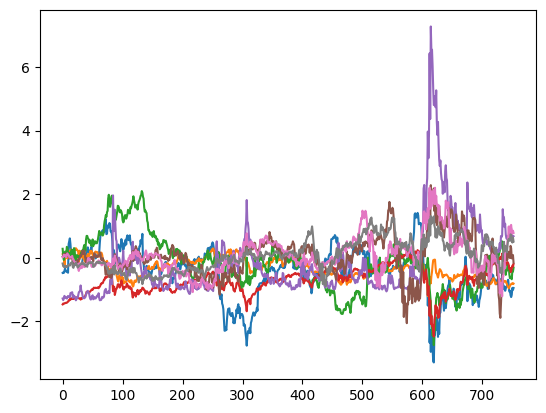

In [386]:
plt.plot(X_train1)

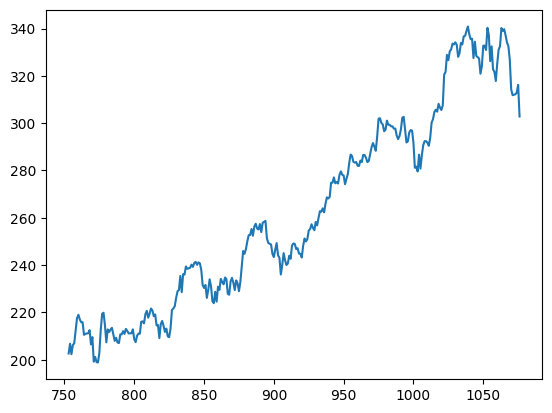

In [387]:
plt.plot(Y_test1)

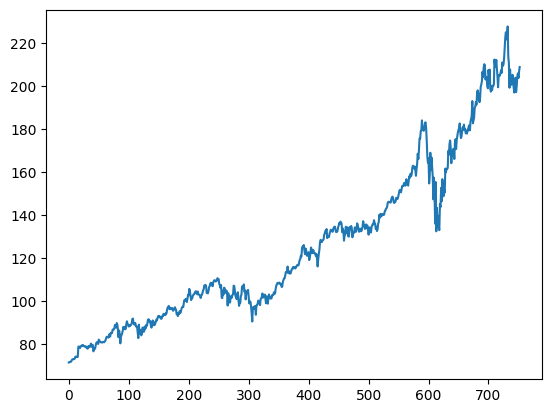

In [388]:
plt.plot(Y_train1)

In [389]:
X_test2

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
477,-0.564774,-0.774437,-1.455693,-0.628642,-0.140855,0.033231,0.315812,0.435169
379,-0.105065,-0.103598,-0.090978,-0.600261,-0.734669,0.344655,0.124495,0.182385
60,0.116266,0.103309,0.729558,-0.955120,-1.114148,0.072273,-0.080265,-0.122212
78,1.093907,-0.450583,1.838389,-0.484699,-1.109463,-0.610552,-0.212791,-0.446263
1071,1.635878,0.517121,0.804617,1.942516,-0.096348,-2.421890,-2.751938,-3.043398
...,...,...,...,...,...,...,...,...
407,-0.504976,-0.247533,-0.653923,-0.716951,-0.496909,0.400944,-0.030440,0.598654
674,-0.428166,-0.595803,-0.585687,-0.392156,0.821896,0.263326,0.355228,0.130844
990,0.839708,-0.251388,1.272032,1.496415,0.046542,1.918196,-0.242303,-1.474481
118,0.218809,-0.884958,1.935625,-1.083199,0.055912,-0.096461,-0.023268,-0.464263


In [390]:
X_train2

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
663,-1.067040,-0.545683,-1.303869,-0.886722,0.873431,0.857093,0.674278,0.825946
193,-0.156681,0.067325,0.233142,-0.904131,-0.933778,0.122986,-0.377919,-0.458553
387,-0.344198,0.006924,-0.201861,-0.510894,-0.952518,0.159614,-0.072587,0.066363
470,-0.391421,-0.692188,-1.643342,-0.603927,-0.430149,-0.512097,0.246842,0.340292
917,1.272986,-0.266810,1.826448,1.460943,-0.446546,1.603573,1.030336,0.407500
...,...,...,...,...,...,...,...,...
744,-0.861643,-0.956926,-0.258155,-0.226688,0.618102,0.191619,0.985566,0.596316
959,1.102910,-0.234681,1.335150,1.576544,-0.262663,-0.611230,0.950233,-0.810068
1004,0.999992,-0.049622,0.628910,1.307055,0.303041,1.956111,0.359809,-1.807874
1057,0.291839,0.249814,0.192201,1.823595,-0.147882,-3.010286,-3.134689,-3.043718


In [391]:
y_test2

,Adj Close
,MSFT
477,134.199615
379,115.961700
60,81.168480
78,88.695129
1071,311.842529
...,...
407,122.888855
674,182.601929
990,294.523346


In [392]:
y_train2

,Adj Close
,MSFT
663,178.229752
193,100.466072
387,121.027023
470,133.364014
917,247.133148
...,...
744,199.031479
959,283.577606
1004,286.698883


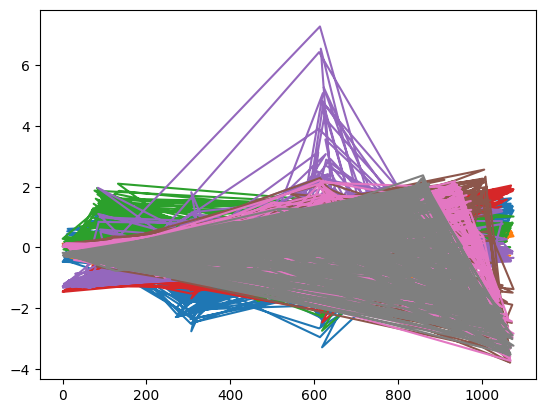

In [393]:
plt.plot(X_train2)

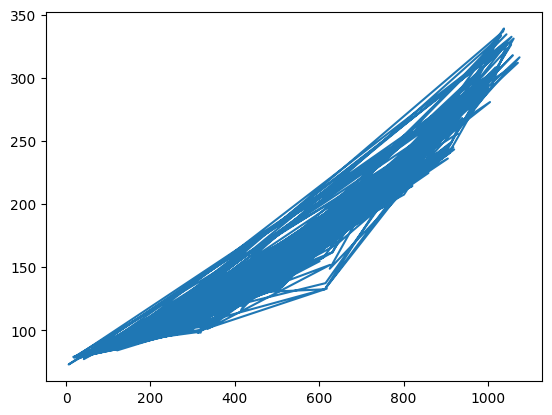

In [394]:
plt.plot(y_test2)

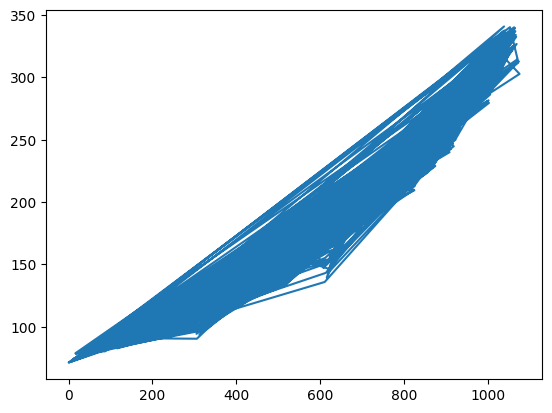

In [395]:
plt.plot(y_train2)

In [396]:
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }

In [397]:
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

In [398]:
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100]
ep_list = [0.1, 1, 5]
gamma = [0.01, 0.1]
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [399]:
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.472958,0.122586,0.284319,-1.465231,-1.279291,0.040651,0.022152,-0.178815
1,-0.456268,0.109734,0.052318,-1.437030,-1.330825,0.061980,0.027228,-0.266734
2,-0.472958,0.102023,-0.065389,-1.437457,-1.276949,0.117952,0.097032,-0.249042
3,-0.409680,-0.267452,0.006258,-1.440580,-1.197305,0.121259,0.060710,-0.297954
4,-0.332492,0.033911,0.193907,-1.423323,-1.226586,0.108883,0.088321,-0.268756
...,...,...,...,...,...,...,...,...
1072,1.379700,0.500415,0.746617,1.900211,-0.110403,-2.486285,-2.437485,-2.986790
1073,1.334335,0.478567,0.821676,1.899019,-0.209958,-1.887793,-2.932726,-3.020493
1074,1.352124,0.418166,0.794382,1.858660,-0.134999,-1.490107,-2.979874,-2.895924
1075,1.159993,0.449009,0.888206,1.904066,-0.250951,-1.483219,-3.031777,-3.016106


In [400]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid = GridSearchCV( estimator=model, n_jobs = 1,verbose = 10,cv = 2,scoring = 'neg_mean_squared_error',param_grid = params )

    grid_result1 = grid.fit(X_train1, Y_train1)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/2; 1/4] END fit_intercept=True, normalize=True;, score=-423.425 total time=   0.0s
[CV 2/2; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/2; 1/4] END fit_intercept=True, normalize=True;, score=-1918.974 total time=   0.0s
[CV 1/2; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/2; 2/4] END fit_intercept=True, normalize=False;, score=-423.425 total time=   0.0s
[CV 2/2; 2/4] START fit_intercept=True, normalize=False.........................
[CV 2/2; 2/4] END fit_intercept=True, normalize=False;, score=-1918.974 total time=   0.0s
[CV 1/2; 3/4] START fit_intercept=False, normalize=True.........................
[CV 1/2; 3/4] END fit_intercept=False, normalize=True;, score=-6710.942 total time=   0.0s
[CV 2/2; 3/4] START fit_intercept=False, normalize=True.........................
[CV 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-package

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2; 1/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear.....
[CV 1/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-775.060 total time=   0.0s
[CV 2/2; 1/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear.....
[CV 2/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-2101.609 total time=   0.0s
[CV 1/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........
[CV 1/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3466.934 total time=   0.0s
[CV 2/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3616.992 total time=   0.0s
[CV 1/2; 3/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.......
[CV 1/2; 3/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-3032.672 total time=   0.0s
[CV 2/2; 3/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.......
[CV 2/2; 3/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-4621.486 total time=   0.0s
[CV 1/2; 4/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear......
[CV 1/2; 4/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-775.060 total time=   0.0s
[CV 2/2; 4/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear......
[CV 2/2; 4/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-2101.609 total time=   0.0s
[CV 1/2; 5/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 5/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-2135.490 total time=   0.0s
[CV 2/2; 5/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.........
[CV 2/2; 5/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3335.599 total time=   0.0s
[CV 1/2; 6/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=poly........
[CV 1/2; 6/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-3889.588 total time=   0.0s
[CV 2/2; 6/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=poly........
[CV 2/2; 6/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-3829.017 total time=   0.0s
[CV 1/2; 7/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear.......
[CV 1/2; 7/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-791.383 total time=   0.0s
[CV 2/2; 7/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear.......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 7/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-2202.580 total time=   0.0s
[CV 1/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 1/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-3511.411 total time=   0.0s
[CV 2/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 2/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-3663.952 total time=   0.0s
[CV 1/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 1/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-3097.732 total time=   0.0s
[CV 2/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 2/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-4653.219 total time=   0.0s
[CV 1/2; 10/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear.......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 10/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-791.383 total time=   0.0s
[CV 2/2; 10/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear.......
[CV 2/2; 10/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-2202.580 total time=   0.0s
[CV 1/2; 11/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf..........
[CV 1/2; 11/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-2143.130 total time=   0.0s
[CV 2/2; 11/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf..........
[CV 2/2; 11/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-3325.116 total time=   0.0s
[CV 1/2; 12/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=poly.........
[CV 1/2; 12/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-3873.943 total time=   0.0s
[CV 2/2; 12/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=poly.........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 12/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-3830.492 total time=   0.0s
[CV 1/2; 13/72] START C=10, degree=2, epsilon=5, gamma=0.01, kernel=linear......
[CV 1/2; 13/72] END C=10, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-861.372 total time=   0.0s
[CV 2/2; 13/72] START C=10, degree=2, epsilon=5, gamma=0.01, kernel=linear......
[CV 2/2; 13/72] END C=10, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-1891.952 total time=   0.0s
[CV 1/2; 14/72] START C=10, degree=2, epsilon=5, gamma=0.01, kernel=rbf.........
[CV 1/2; 14/72] END C=10, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-3372.503 total time=   0.0s
[CV 2/2; 14/72] START C=10, degree=2, epsilon=5, gamma=0.01, kernel=rbf.........
[CV 2/2; 14/72] END C=10, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-3684.599 total time=   0.0s
[CV 1/2; 15/72] START C=10, degree=2, epsilon=5, gamma=0.01, kernel=poly........
[CV 1/2; 15/72] END C=10, degree=2, epsilon=5, gamma=0.

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

[CV 1/2; 16/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-861.372 total time=   0.0s
[CV 2/2; 16/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear.......
[CV 2/2; 16/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-1891.952 total time=   0.0s
[CV 1/2; 17/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 1/2; 17/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-2326.012 total time=   0.0s
[CV 2/2; 17/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 2/2; 17/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-3111.329 total time=   0.0s
[CV 1/2; 18/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly.........
[CV 1/2; 18/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-3819.502 total time=   0.0s
[CV 2/2; 18/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly.........
[CV 2/2; 18/72] END C=10, degree=2, epsilon=5, gamma=0.1, k

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 19/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=linear;, score=-2101.609 total time=   0.0s
[CV 1/2; 20/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf.......
[CV 1/2; 20/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3466.934 total time=   0.0s
[CV 2/2; 20/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf.......
[CV 2/2; 20/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-3616.992 total time=   0.0s
[CV 1/2; 21/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 1/2; 21/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-3212.162 total time=   0.0s
[CV 2/2; 21/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 2/2; 21/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-4612.727 total time=   0.0s
[CV 1/2; 22/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear.....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 22/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-775.060 total time=   0.0s
[CV 2/2; 22/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear.....
[CV 2/2; 22/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-2101.609 total time=   0.0s
[CV 1/2; 23/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf........
[CV 1/2; 23/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-2135.490 total time=   0.0s
[CV 2/2; 23/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf........
[CV 2/2; 23/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3335.599 total time=   0.0s
[CV 1/2; 24/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly.......
[CV 1/2; 24/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-3402.104 total time=   0.0s
[CV 2/2; 24/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly.......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 24/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-4159.231 total time=   0.0s
[CV 1/2; 25/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear......
[CV 1/2; 25/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-791.383 total time=   0.0s
[CV 2/2; 25/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear......
[CV 2/2; 25/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-2202.580 total time=   0.0s
[CV 1/2; 26/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf.........
[CV 1/2; 26/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-3511.411 total time=   0.0s
[CV 2/2; 26/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf.........
[CV 2/2; 26/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-3663.952 total time=   0.0s
[CV 1/2; 27/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 27/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-3199.026 total time=   0.0s
[CV 2/2; 27/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly........
[CV 2/2; 27/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-4616.682 total time=   0.0s
[CV 1/2; 28/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear.......
[CV 1/2; 28/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-791.383 total time=   0.0s
[CV 2/2; 28/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear.......
[CV 2/2; 28/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-2202.580 total time=   0.0s
[CV 1/2; 29/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf..........
[CV 1/2; 29/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-2143.130 total time=   0.0s
[CV 2/2; 29/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf..........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 29/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-3325.116 total time=   0.0s
[CV 1/2; 30/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=poly.........
[CV 1/2; 30/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-3379.219 total time=   0.0s
[CV 2/2; 30/72] START C=10, degree=3, epsilon=1, gamma=0.1, kernel=poly.........
[CV 2/2; 30/72] END C=10, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-4156.756 total time=   0.0s
[CV 1/2; 31/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=linear......
[CV 1/2; 31/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-861.372 total time=   0.0s
[CV 2/2; 31/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=linear......
[CV 2/2; 31/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-1891.952 total time=   0.0s
[CV 1/2; 32/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=rbf.........
[CV 1/2; 32/72] END C=10, degree=3, epsilon=5, gamma=0.0

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 32/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-3684.599 total time=   0.0s
[CV 1/2; 33/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=poly........
[CV 1/2; 33/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-3264.093 total time=   0.0s
[CV 2/2; 33/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=poly........
[CV 2/2; 33/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-4685.711 total time=   0.0s
[CV 1/2; 34/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=linear.......
[CV 1/2; 34/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=linear;, score=-861.372 total time=   0.0s
[CV 2/2; 34/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=linear.......
[CV 2/2; 34/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=linear;, score=-1891.952 total time=   0.0s
[CV 1/2; 35/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 1/2; 35/72] END C=10, degree=3, epsilon=5, gamma=0.

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 36/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-3301.653 total time=   0.0s
[CV 2/2; 36/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=poly.........
[CV 2/2; 36/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-4423.476 total time=   0.0s
[CV 1/2; 37/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear...
[CV 1/2; 37/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-681.530 total time=   0.0s
[CV 2/2; 37/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear...


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 37/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-2098.118 total time=   0.1s
[CV 1/2; 38/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 1/2; 38/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1351.357 total time=   0.0s
[CV 2/2; 38/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 2/2; 38/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-2438.937 total time=   0.0s
[CV 1/2; 39/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 1/2; 39/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-3177.093 total time=   0.0s
[CV 2/2; 39/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 2/2; 39/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-4537.424 total time=   0.0s
[CV 1/2; 40/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-681.530 total time=   0.0s
[CV 2/2; 40/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear....
[CV 2/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-2098.118 total time=   0.1s
[CV 1/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-1216.626 total time=   0.0s
[CV 2/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 2/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3343.698 total time=   0.0s
[CV 1/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 1/2; 42/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-2788.916 total time=   0.0s
[CV 2/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 2/2; 42/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-3228.711 total time=   0.0s
[CV 1/2; 43/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear.....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 43/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-650.694 total time=   0.0s
[CV 2/2; 43/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear.....
[CV 2/2; 43/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-2100.701 total time=   0.0s
[CV 1/2; 44/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf........
[CV 1/2; 44/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-1397.438 total time=   0.0s
[CV 2/2; 44/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf........
[CV 2/2; 44/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-2505.322 total time=   0.0s
[CV 1/2; 45/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly.......
[CV 1/2; 45/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-3203.407 total time=   0.0s
[CV 2/2; 45/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly.......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 45/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-4538.464 total time=   0.0s
[CV 1/2; 46/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear......
[CV 1/2; 46/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-650.694 total time=   0.0s
[CV 2/2; 46/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear......
[CV 2/2; 46/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-2100.701 total time=   0.0s
[CV 1/2; 47/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 1/2; 47/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-1248.689 total time=   0.0s
[CV 2/2; 47/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf.........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 47/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-3311.001 total time=   0.0s
[CV 1/2; 48/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly........
[CV 1/2; 48/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-2784.836 total time=   0.0s
[CV 2/2; 48/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly........
[CV 2/2; 48/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-3318.593 total time=   0.0s
[CV 1/2; 49/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear.....
[CV 1/2; 49/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-683.901 total time=   0.0s
[CV 2/2; 49/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear.....
[CV 2/2; 49/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-1938.565 total time=   0.0s
[CV 1/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-1664.779 total time=   0.0s
[CV 2/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-2286.233 total time=   0.0s
[CV 1/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......
[CV 1/2; 51/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-3159.809 total time=   0.0s
[CV 2/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......
[CV 2/2; 51/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-4582.171 total time=   0.0s
[CV 1/2; 52/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear......
[CV 1/2; 52/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-683.901 total time=   0.0s
[CV 2/2; 52/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear......
[CV 2/2; 52/72] END C=100, degree=2, epsilon=5, gamm

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 53/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-1273.716 total time=   0.0s
[CV 2/2; 53/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=rbf.........
[CV 2/2; 53/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-3370.081 total time=   0.0s
[CV 1/2; 54/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly........
[CV 1/2; 54/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-2648.478 total time=   0.0s
[CV 2/2; 54/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly........
[CV 2/2; 54/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-3620.943 total time=   0.0s
[CV 1/2; 55/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear...
[CV 1/2; 55/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear;, score=-681.530 total time=   0.0s
[CV 2/2; 55/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear...


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 55/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear;, score=-2098.118 total time=   0.0s
[CV 1/2; 56/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 1/2; 56/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1351.357 total time=   0.0s
[CV 2/2; 56/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 2/2; 56/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-2438.937 total time=   0.0s
[CV 1/2; 57/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 1/2; 57/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-3220.255 total time=   0.0s
[CV 2/2; 57/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 2/2; 57/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-4616.690 total time=   0.0s
[CV 1/2; 58/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 58/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-681.530 total time=   0.0s
[CV 2/2; 58/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear....
[CV 2/2; 58/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-2098.118 total time=   0.0s
[CV 1/2; 59/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 1/2; 59/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-1216.626 total time=   0.0s
[CV 2/2; 59/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf.......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 59/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-3343.698 total time=   0.0s
[CV 1/2; 60/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 1/2; 60/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-3281.045 total time=   0.0s
[CV 2/2; 60/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 2/2; 60/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-4487.091 total time=   0.0s
[CV 1/2; 61/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear.....
[CV 1/2; 61/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-650.694 total time=   0.0s
[CV 2/2; 61/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear.....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 61/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-2100.701 total time=   0.0s
[CV 1/2; 62/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf........
[CV 1/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-1397.438 total time=   0.0s
[CV 2/2; 62/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf........
[CV 2/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-2505.322 total time=   0.0s
[CV 1/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 1/2; 63/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-3234.443 total time=   0.0s
[CV 2/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 2/2; 63/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-4620.367 total time=   0.0s
[CV 1/2; 64/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 64/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-650.694 total time=   0.0s
[CV 2/2; 64/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear......
[CV 2/2; 64/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-2100.701 total time=   0.0s
[CV 1/2; 65/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 1/2; 65/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-1248.689 total time=   0.0s
[CV 2/2; 65/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 2/2; 65/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-3311.001 total time=   0.0s
[CV 1/2; 66/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 66/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-3233.530 total time=   0.0s
[CV 2/2; 66/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly........
[CV 2/2; 66/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-4185.942 total time=   0.0s
[CV 1/2; 67/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear.....
[CV 1/2; 67/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-683.901 total time=   0.0s
[CV 2/2; 67/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear.....
[CV 2/2; 67/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-1938.565 total time=   0.0s
[CV 1/2; 68/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf........
[CV 1/2; 68/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-1664.779 total time=   0.0s
[CV 2/2; 68/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 68/72] END C=100, degree=3, epsilon=5, ga

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 69/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-3274.008 total time=   0.0s
[CV 2/2; 69/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly.......
[CV 2/2; 69/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-4672.009 total time=   0.0s
[CV 1/2; 70/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear......
[CV 1/2; 70/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear;, score=-683.901 total time=   0.0s
[CV 2/2; 70/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear......
[CV 2/2; 70/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear;, score=-1938.565 total time=   0.0s
[CV 1/2; 71/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf.........
[CV 1/2; 71/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf;, score=-1273.716 total time=   0.0s
[CV 2/2; 71/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf.........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 71/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf;, score=-3370.081 total time=   0.0s
[CV 1/2; 72/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly........
[CV 1/2; 72/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-3349.410 total time=   0.0s
[CV 2/2; 72/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly........
[CV 2/2; 72/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-3738.130 total time=   0.0s


In [401]:
print('Best params: ',grid_result1.best_params_)
print('Best score: ', grid_result1.best_score_)
best_search_c_1_btw = grid_result1.best_params_['C']
best_search_degree_1_btw = grid_result1.best_params_['degree']
best_search_gamma_1_btw = grid_result1.best_params_['gamma']
best_search_epsilon_1_btw = grid_result1.best_params_['epsilon']

Best params:  {'C': 100, 'degree': 2, 'epsilon': 5, 'gamma': 0.01, 'kernel': 'linear'}
Best score:  -1311.2332509334283


In [402]:
means1 = grid_result1.cv_results_['mean_test_score']
stds1 = grid_result1.cv_results_['std_test_score']
params1 = grid_result1.cv_results_['params']
bar_mean1_linear = []
bar_stds1_linear = []
bar_mean1_poly = []
bar_stds1_poly = []
bar_mean1_rbf = []
bar_stds1_rbf = []
for mean1, stdev1, param1 in zip(means1, stds1, params1):
    print("%f (%f) with: %r" % (mean1, stdev1, param1))
    if param1['kernel'] == 'linear':
        bar_mean1_linear.append(mean1)
        bar_stds1_linear.append(stdev1)
    elif param1['kernel'] == 'poly': 
        bar_mean1_poly.append(mean1)
        bar_stds1_poly.append(stdev1)
    else:
        bar_mean1_rbf.append(mean1)
        bar_stds1_rbf.append(stdev1)

-1438.334805 (663.274598) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
-3541.962985 (75.028774) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-3827.078989 (794.407213) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
-1438.334805 (663.274598) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
-2735.544561 (600.054116) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-3859.302576 (30.285185) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
-1496.981394 (705.598159) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'linear'}
-3587.681314 (76.270619) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-3875.475116 (777.743406) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'poly'}
-1496.981394 (705.598159) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gam

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


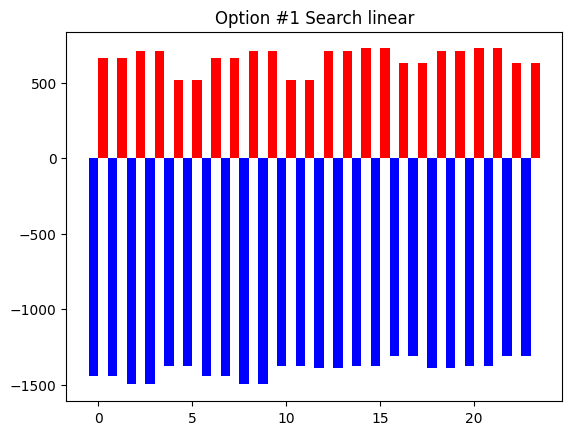

In [403]:
x = np.arange(len(bar_mean1_linear))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #1 Search linear')
rect1 = plt.bar(x-w/2,bar_mean1_linear,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds1_linear,w,color = 'r')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


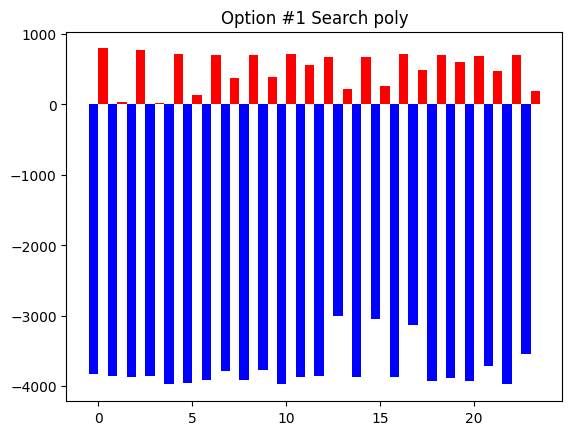

In [404]:
x = np.arange(len(bar_mean1_poly))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #1 Search poly')
rect1 = plt.bar(x-w/2,bar_mean1_poly,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds1_poly,w,color = 'r')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


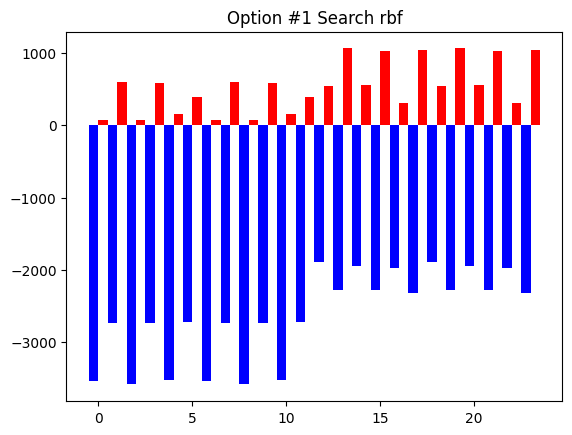

In [405]:
x = np.arange(len(bar_mean1_rbf))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #1 Search rbf')
rect1 = plt.bar(x-w/2,bar_mean1_rbf,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds1_rbf,w,color = 'r')
plt.show()

In [406]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid = GridSearchCV(estimator=model, n_jobs = 1, verbose = 10, cv = 2, scoring = 'neg_mean_squared_error', param_grid = params )

    grid_result2 = grid.fit(X_train2, y_train2)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/2; 1/4] END fit_intercept=True, normalize=True;, score=-217.161 total time=   0.0s
[CV 2/2; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/2; 1/4] END fit_intercept=True, normalize=True;, score=-232.416 total time=   0.0s
[CV 1/2; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/2; 2/4] END fit_intercept=True, normalize=False;, score=-217.161 total time=   0.0s
[CV 2/2; 2/4] START fit_intercept=True, normalize=False.........................
[CV 2/2; 2/4] END fit_intercept=True, normalize=False;, score=-232.416 total time=   0.0s
[CV 1/2; 3/4] START fit_intercept=False, normalize=True.........................
[CV 1/2; 3/4] END fit_intercept=False, normalize=True;, score=-11509.575 total time=   0.0s
[CV 2/2; 3/4] START fit_intercept=False, normalize=True.........................
[CV 2

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-package

[CV 1/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-244.749 total time=   0.0s
[CV 2/2; 1/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear.....
[CV 2/2; 1/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-248.329 total time=   0.0s
[CV 1/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........
[CV 1/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-949.093 total time=   0.0s
[CV 2/2; 2/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf........
[CV 2/2; 2/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1505.389 total time=   0.0s
[CV 1/2; 3/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.......
[CV 1/2; 3/72] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5146.014 total time=   0.0s
[CV 2/2; 3/72] START C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.......
[CV 2/2; 3/72] END C=10, degree=2, epsilon=0.1, gam

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 4/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-244.749 total time=   0.0s
[CV 2/2; 4/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear......
[CV 2/2; 4/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-248.329 total time=   0.0s
[CV 1/2; 5/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.........
[CV 1/2; 5/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-205.810 total time=   0.0s
[CV 2/2; 5/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.........
[CV 2/2; 5/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-202.439 total time=   0.0s
[CV 1/2; 6/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=poly........
[CV 1/2; 6/72] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-1051.043 total time=   0.0s
[CV 2/2; 6/72] START C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=poly........
[CV 2/2; 6/72] END C=10, degree=2, epsilon=0.1, gamma=0.1

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

[CV 1/2; 7/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-246.235 total time=   0.0s
[CV 2/2; 7/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear.......
[CV 2/2; 7/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-247.160 total time=   0.0s
[CV 1/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 1/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-950.748 total time=   0.0s
[CV 2/2; 8/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf..........
[CV 2/2; 8/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-1517.829 total time=   0.0s
[CV 1/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 1/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-5170.262 total time=   0.0s
[CV 2/2; 9/72] START C=10, degree=2, epsilon=1, gamma=0.01, kernel=poly.........
[CV 2/2; 9/72] END C=10, degree=2, epsilon=1, gamma=0.01, ker

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 10/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-246.235 total time=   0.0s
[CV 2/2; 10/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear.......
[CV 2/2; 10/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=linear;, score=-247.160 total time=   0.0s
[CV 1/2; 11/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf..........
[CV 1/2; 11/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-205.287 total time=   0.0s
[CV 2/2; 11/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf..........
[CV 2/2; 11/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-206.393 total time=   0.0s
[CV 1/2; 12/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=poly.........
[CV 1/2; 12/72] END C=10, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-1056.969 total time=   0.0s
[CV 2/2; 12/72] START C=10, degree=2, epsilon=1, gamma=0.1, kernel=poly.........
[CV 2/2; 12/72] END C=10, degree=2, epsilon=1, gamma=0.1, kern

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 16/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-231.784 total time=   0.0s
[CV 2/2; 16/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear.......
[CV 2/2; 16/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-236.472 total time=   0.0s
[CV 1/2; 17/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 1/2; 17/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-214.816 total time=   0.0s
[CV 2/2; 17/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 2/2; 17/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-218.435 total time=   0.0s
[CV 1/2; 18/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly.........
[CV 1/2; 18/72] END C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-1053.817 total time=   0.0s
[CV 2/2; 18/72] START C=10, degree=2, epsilon=5, gamma=0.1, kernel=poly.........
[CV 2/2; 18/72] END C=10, degree=2, epsilon=5, gamma=0.1, kern

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 19/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=linear;, score=-248.329 total time=   0.0s
[CV 1/2; 20/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf.......
[CV 1/2; 20/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-949.093 total time=   0.0s
[CV 2/2; 20/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf.......
[CV 2/2; 20/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-1505.389 total time=   0.0s
[CV 1/2; 21/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 1/2; 21/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5442.822 total time=   0.0s
[CV 2/2; 21/72] START C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 2/2; 21/72] END C=10, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-6385.722 total time=   0.0s
[CV 1/2; 22/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear.....
[CV 1/2; 22/72] END C=10, degree=3, epsilon=0.1

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 22/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-248.329 total time=   0.0s
[CV 1/2; 23/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf........
[CV 1/2; 23/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-205.810 total time=   0.0s
[CV 2/2; 23/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf........
[CV 2/2; 23/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-202.439 total time=   0.0s
[CV 1/2; 24/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly.......
[CV 1/2; 24/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-1420.352 total time=   0.0s
[CV 2/2; 24/72] START C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly.......
[CV 2/2; 24/72] END C=10, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-1320.996 total time=   0.0s
[CV 1/2; 25/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 25/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-246.235 total time=   0.0s
[CV 2/2; 25/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear......
[CV 2/2; 25/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=linear;, score=-247.160 total time=   0.0s
[CV 1/2; 26/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf.........
[CV 1/2; 26/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-950.748 total time=   0.0s
[CV 2/2; 26/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf.........
[CV 2/2; 26/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-1517.829 total time=   0.0s
[CV 1/2; 27/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly........
[CV 1/2; 27/72] END C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-5454.853 total time=   0.0s
[CV 2/2; 27/72] START C=10, degree=3, epsilon=1, gamma=0.01, kernel=poly........
[CV 2/2; 27/72] END C=10, degree=3, epsilon=1, gamma=0.0

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 31/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-231.784 total time=   0.0s
[CV 2/2; 31/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=linear......
[CV 2/2; 31/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=linear;, score=-236.472 total time=   0.0s
[CV 1/2; 32/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=rbf.........
[CV 1/2; 32/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-954.584 total time=   0.0s
[CV 2/2; 32/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=rbf.........
[CV 2/2; 32/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-1544.377 total time=   0.0s
[CV 1/2; 33/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=poly........
[CV 1/2; 33/72] END C=10, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-5408.209 total time=   0.0s
[CV 2/2; 33/72] START C=10, degree=3, epsilon=5, gamma=0.01, kernel=poly........
[CV 2/2; 33/72] END C=10, degree=3, epsilon=5, gamma=0.0

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 34/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=linear;, score=-236.472 total time=   0.0s
[CV 1/2; 35/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 1/2; 35/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=rbf;, score=-214.816 total time=   0.0s
[CV 2/2; 35/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=rbf..........
[CV 2/2; 35/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=rbf;, score=-218.435 total time=   0.0s
[CV 1/2; 36/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=poly.........
[CV 1/2; 36/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-1387.665 total time=   0.0s
[CV 2/2; 36/72] START C=10, degree=3, epsilon=5, gamma=0.1, kernel=poly.........
[CV 2/2; 36/72] END C=10, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-1327.295 total time=   0.0s
[CV 1/2; 37/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear...


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 37/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-245.450 total time=   0.0s
[CV 2/2; 37/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear...
[CV 2/2; 37/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=linear;, score=-244.859 total time=   0.1s
[CV 1/2; 38/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 1/2; 38/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-211.770 total time=   0.0s
[CV 2/2; 38/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 2/2; 38/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-209.251 total time=   0.0s
[CV 1/2; 39/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 1/2; 39/72] END C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-3297.124 total time=   0.0s
[CV 2/2; 39/72] START C=100, degree=2, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 2/2; 39/72] END C=100, degree=2, epsil

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-245.450 total time=   0.0s
[CV 2/2; 40/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 40/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=linear;, score=-244.859 total time=   0.1s
[CV 1/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 1/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-56.122 total time=   0.0s
[CV 2/2; 41/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 2/2; 41/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-64.646 total time=   0.0s
[CV 1/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 1/2; 42/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-508.549 total time=   0.0s
[CV 2/2; 42/72] START C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 2/2; 42/72] END C=100, degree=2, epsilon=0.1, gamma=0.1, kernel=poly;, score=-584.686 total time=   0.0s
[CV 1/2; 43/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear.....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 43/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-247.271 total time=   0.0s
[CV 2/2; 43/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear.....
[CV 2/2; 43/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=linear;, score=-243.839 total time=   0.0s
[CV 1/2; 44/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf........
[CV 1/2; 44/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-207.645 total time=   0.0s
[CV 2/2; 44/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf........
[CV 2/2; 44/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=rbf;, score=-208.151 total time=   0.0s
[CV 1/2; 45/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly.......
[CV 1/2; 45/72] END C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly;, score=-3277.608 total time=   0.0s
[CV 2/2; 45/72] START C=100, degree=2, epsilon=1, gamma=0.01, kernel=poly.......
[CV 2/2; 45/72] END C=100, degree=2, epsilon=1, gamm

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 47/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-55.915 total time=   0.0s
[CV 2/2; 47/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 2/2; 47/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=rbf;, score=-63.874 total time=   0.0s
[CV 1/2; 48/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly........
[CV 1/2; 48/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-505.816 total time=   0.0s
[CV 2/2; 48/72] START C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly........
[CV 2/2; 48/72] END C=100, degree=2, epsilon=1, gamma=0.1, kernel=poly;, score=-579.924 total time=   0.0s
[CV 1/2; 49/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear.....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 49/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-233.169 total time=   0.0s
[CV 2/2; 49/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear.....
[CV 2/2; 49/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=linear;, score=-236.039 total time=   0.0s
[CV 1/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........
[CV 1/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-201.823 total time=   0.0s
[CV 2/2; 50/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 50/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=rbf;, score=-207.809 total time=   0.0s
[CV 1/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......
[CV 1/2; 51/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-3217.537 total time=   0.0s
[CV 2/2; 51/72] START C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly.......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 51/72] END C=100, degree=2, epsilon=5, gamma=0.01, kernel=poly;, score=-3613.766 total time=   0.0s
[CV 1/2; 52/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear......
[CV 1/2; 52/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-233.169 total time=   0.0s
[CV 2/2; 52/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear......
[CV 2/2; 52/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=linear;, score=-236.039 total time=   0.0s
[CV 1/2; 53/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=rbf.........
[CV 1/2; 53/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-60.075 total time=   0.0s
[CV 2/2; 53/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=rbf.........


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 53/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=rbf;, score=-67.501 total time=   0.0s
[CV 1/2; 54/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly........
[CV 1/2; 54/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-495.067 total time=   0.0s
[CV 2/2; 54/72] START C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly........
[CV 2/2; 54/72] END C=100, degree=2, epsilon=5, gamma=0.1, kernel=poly;, score=-564.656 total time=   0.0s
[CV 1/2; 55/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear...
[CV 1/2; 55/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear;, score=-245.450 total time=   0.0s
[CV 2/2; 55/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear...


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 55/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=linear;, score=-244.859 total time=   0.1s
[CV 1/2; 56/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 1/2; 56/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-211.770 total time=   0.0s
[CV 2/2; 56/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf......
[CV 2/2; 56/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=rbf;, score=-209.251 total time=   0.0s
[CV 1/2; 57/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 1/2; 57/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-4918.175 total time=   0.0s
[CV 2/2; 57/72] START C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly.....
[CV 2/2; 57/72] END C=100, degree=3, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5878.987 total time=   0.0s
[CV 1/2; 58/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/2; 58/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-245.450 total time=   0.0s
[CV 2/2; 58/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear....


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 58/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=linear;, score=-244.859 total time=   0.1s
[CV 1/2; 59/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 1/2; 59/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-56.122 total time=   0.0s
[CV 2/2; 59/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf.......
[CV 2/2; 59/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=rbf;, score=-64.646 total time=   0.0s
[CV 1/2; 60/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 1/2; 60/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-594.664 total time=   0.0s
[CV 2/2; 60/72] START C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly......
[CV 2/2; 60/72] END C=100, degree=3, epsilon=0.1, gamma=0.1, kernel=poly;, score=-609.916 total time=   0.0s
[CV 1/2; 61/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=linear.....
[CV 1/2; 61/72] END C=100, degree=3, epsilon=1, gamm

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-207.645 total time=   0.0s
[CV 2/2; 62/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf........
[CV 2/2; 62/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=rbf;, score=-208.151 total time=   0.0s
[CV 1/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 1/2; 63/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-4919.866 total time=   0.0s
[CV 2/2; 63/72] START C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly.......
[CV 2/2; 63/72] END C=100, degree=3, epsilon=1, gamma=0.01, kernel=poly;, score=-5885.903 total time=   0.0s
[CV 1/2; 64/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear......
[CV 1/2; 64/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-247.271 total time=   0.0s
[CV 2/2; 64/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 64/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=linear;, score=-243.839 total time=   0.0s
[CV 1/2; 65/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 1/2; 65/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-55.915 total time=   0.0s
[CV 2/2; 65/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf.........
[CV 2/2; 65/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=rbf;, score=-63.874 total time=   0.0s
[CV 1/2; 66/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly........
[CV 1/2; 66/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-594.696 total time=   0.0s
[CV 2/2; 66/72] START C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly........
[CV 2/2; 66/72] END C=100, degree=3, epsilon=1, gamma=0.1, kernel=poly;, score=-602.644 total time=   0.0s
[CV 1/2; 67/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=linear.....
[CV 1/2; 67/72] END C=100, degree=3, epsilon=5, gamma=0.01, ke

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/2; 68/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-201.823 total time=   0.0s
[CV 2/2; 68/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf........
[CV 2/2; 68/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=rbf;, score=-207.809 total time=   0.0s
[CV 1/2; 69/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly.......
[CV 1/2; 69/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-4912.702 total time=   0.0s
[CV 2/2; 69/72] START C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly.......
[CV 2/2; 69/72] END C=100, degree=3, epsilon=5, gamma=0.01, kernel=poly;, score=-5891.021 total time=   0.0s
[CV 1/2; 70/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear......
[CV 1/2; 70/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear;, score=-233.169 total time=   0.0s
[CV 2/2; 70/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear......


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/2; 70/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=linear;, score=-236.039 total time=   0.0s
[CV 1/2; 71/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf.........
[CV 1/2; 71/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf;, score=-60.075 total time=   0.0s
[CV 2/2; 71/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf.........
[CV 2/2; 71/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=rbf;, score=-67.501 total time=   0.0s
[CV 1/2; 72/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly........
[CV 1/2; 72/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-608.025 total time=   0.0s
[CV 2/2; 72/72] START C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly........
[CV 2/2; 72/72] END C=100, degree=3, epsilon=5, gamma=0.1, kernel=poly;, score=-604.520 total time=   0.0s


In [407]:
print('Best params: ',grid_result2.best_params_)
print('Best score: ', grid_result2.best_score_)
best_search_c_2_btw = grid_result2.best_params_['C']
best_search_degree_2_btw = grid_result2.best_params_['degree']
best_search_gamma_2_btw = grid_result2.best_params_['gamma']
best_search_epsilon_2_btw = grid_result2.best_params_['epsilon']

Best params:  {'C': 100, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -59.89436277692016


In [408]:
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
bar_mean2_linear = []
bar_stds2_linear = []
bar_mean2_poly = []
bar_stds2_poly = []
bar_mean2_rbf = []
bar_stds2_rbf = []
for mean2, stdev2, param2 in zip(means2, stds2, params2):
    print("%f (%f) with: %r" % (mean2, stdev2, param2))
    if param2['kernel'] == 'linear':
        bar_mean2_linear.append(mean2)
        bar_stds2_linear.append(stdev2)
    elif param2['kernel'] == 'poly': 
        bar_mean2_poly.append(mean2)
        bar_stds2_poly.append(stdev2)
    else:
        bar_mean2_rbf.append(mean2)
        bar_stds2_rbf.append(stdev2)

-246.539132 (1.789799) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
-1227.240994 (278.147898) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-5634.614927 (488.600932) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
-246.539132 (1.789799) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
-204.124445 (1.685490) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-1049.292214 (1.750577) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
-246.697675 (0.462229) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'linear'}
-1234.288410 (283.540771) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-5627.427399 (457.165142) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'poly'}
-246.697675 (0.462229) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.1, 'ker

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


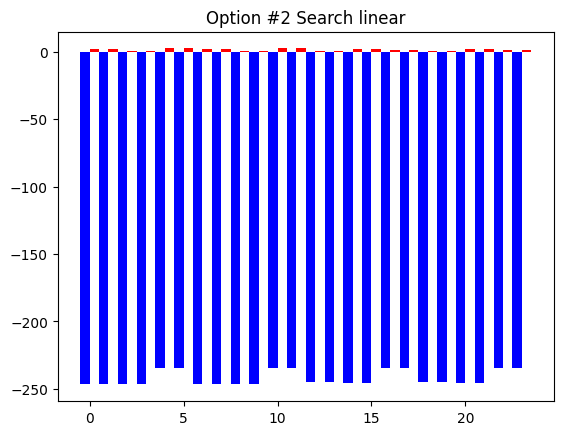

In [409]:
x = np.arange(len(bar_mean2_linear))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #2 Search linear')
rect1 = plt.bar(x-w/2,bar_mean2_linear,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds2_linear,w,color = 'r')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


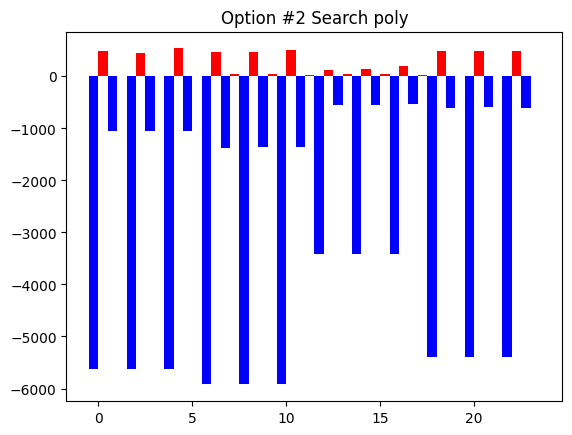

In [410]:
x = np.arange(len(bar_mean2_poly))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #2 Search poly')
rect1 = plt.bar(x-w/2,bar_mean2_poly,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds2_poly,w,color = 'r')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


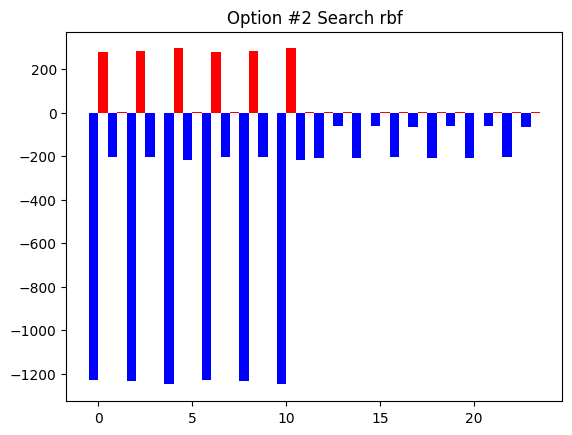

In [411]:
x = np.arange(len(bar_mean2_rbf))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #2 Search rbf')
rect1 = plt.bar(x-w/2,bar_mean2_rbf,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds2_rbf,w,color = 'r')
plt.show()


In [412]:
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }

In [413]:
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)


In [414]:
kernel = ['linear', 'rbf', 'poly']
C_list = list(np.linspace(0.1, 150, 5, dtype = float))
ep_list = list(np.linspace(0.1, 1, 5, dtype = float))
gamma = list(np.linspace(0.01, 0.1, 5, dtype = float))
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [415]:
Model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LM_pred = Model_LM.fit(X_train1, Y_train1).predict(X_test1)
n_clusters_LM = np.unique(LM_pred)
kmeans_LM = KMeans(n_clusters=n_clusters_LM.size,random_state=0)
clusters_LM = kmeans_LM.fit_predict(X_test1)

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Pyth

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

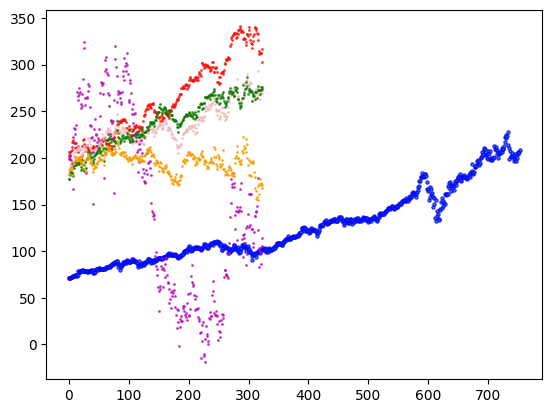

In [416]:
c_val = best_search_c_1_btw
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=best_search_gamma_1_btw)
svr_poly = SVR(kernel='poly', C=c_val, degree=best_search_degree_1_btw)
SVR_Linear = svr_lin.fit(X_train1,Y_train1).predict(X_test1)
SVR_Rbf = svr_rbf.fit(X_train1,Y_train1).predict(X_test1)
SVR_Poly = svr_poly.fit(X_train1,Y_train1).predict(X_test1)

plt.scatter(np.arange(len(Y_train1)),Y_train1, edgecolors='b',alpha=0.75,s=5)
plt.scatter(np.arange(len(Y_test1)),Y_test1, edgecolors='r',alpha=0.75,s=1)
plt.scatter(np.arange(len(LM_pred)),LM_pred, edgecolors='pink',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Linear)),SVR_Linear,edgecolors='green',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Poly)),SVR_Poly, edgecolors='m',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Rbf)),SVR_Rbf, edgecolors='orange',alpha=0.75,s=1)
plt.show()

In [417]:
Model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LM_pred = Model_LM.fit(X_train2, y_train2).predict(X_test2)
n_clusters_LM = np.unique(LM_pred)
kmeans_LM = KMeans(n_clusters=n_clusters_LM.size,random_state=0)
clusters_LM = kmeans_LM.fit_predict(X_test2)

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Pyth

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

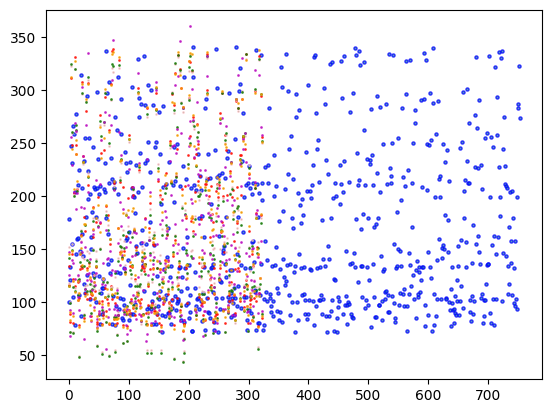

In [418]:
c_val = best_search_c_2_btw
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=best_search_gamma_2_btw)
svr_poly = SVR(kernel='poly', C=c_val, degree=best_search_degree_2_btw)
SVR_Linear = svr_lin.fit(X_train2,y_train2).predict(X_test2)
SVR_Rbf = svr_rbf.fit(X_train2,y_train2).predict(X_test2)
SVR_Poly = svr_poly.fit(X_train2,y_train2).predict(X_test2)
plt.scatter(np.arange(len(Y_train1)),y_train2, edgecolors='b',alpha=0.75,s=5)
plt.scatter(np.arange(len(Y_test1)),y_test2, edgecolors='r',alpha=0.75,s=1)
plt.scatter(np.arange(len(LM_pred)),LM_pred, edgecolors='pink',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Linear)),SVR_Linear,edgecolors='green',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Poly)),SVR_Poly, edgecolors='m',alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Rbf)),SVR_Rbf, edgecolors='orange',alpha=0.75,s=1)
plt.show()

In [419]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR
    grid_rand = RandomizedSearchCV(estimator=model, n_jobs = 1,verbose = 10,cv = 3,scoring = 'neg_mean_squared_error',param_distributions = params)
    grid_rand_result = grid_rand.fit(X_train1, Y_train1)

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklear

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/3; 1/4] END fit_intercept=True, normalize=True;, score=-423.161 total time=   0.0s
[CV 2/3; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/3; 1/4] END fit_intercept=True, normalize=True;, score=-894.090 total time=   0.0s
[CV 3/3; 1/4] START fit_intercept=True, normalize=True..........................
[CV 3/3; 1/4] END fit_intercept=True, normalize=True;, score=-2176.667 total time=   0.0s
[CV 1/3; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/3; 2/4] END fit_intercept=True, normalize=False;, score=-423.161 total time=   0.0s
[CV 2/3; 2/4] START fit_intercept=True, normalize=False.........................
[CV 2/3; 2/4] END fit_intercept=True, normalize=False;, score=-894.090 total time=   0.0s
[CV 3/3; 2/4] START fit_intercept=True, normalize=False.........................
[CV 3/

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/3; 2/10] END C=75.05, degree=3, epsilon=0.325, gamma=0.0325, kernel=rbf;, score=-516.456 total time=   0.0s
[CV 2/3; 2/10] START C=75.05, degree=3, epsilon=0.325, gamma=0.0325, kernel=rbf.
[CV 2/3; 2/10] END C=75.05, degree=3, epsilon=0.325, gamma=0.0325, kernel=rbf;, score=-953.208 total time=   0.0s
[CV 3/3; 2/10] START C=75.05, degree=3, epsilon=0.325, gamma=0.0325, kernel=rbf.
[CV 3/3; 2/10] END C=75.05, degree=3, epsilon=0.325, gamma=0.0325, kernel=rbf;, score=-2647.545 total time=   0.0s
[CV 1/3; 3/10] START C=112.525, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=poly
[CV 1/3; 3/10] END C=112.525, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=poly;, score=-2039.205 total time=   0.0s
[CV 2/3; 3/10] START C=112.525, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=poly


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/3; 3/10] END C=112.525, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=poly;, score=-566.627 total time=   0.0s
[CV 3/3; 3/10] START C=112.525, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=poly
[CV 3/3; 3/10] END C=112.525, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=poly;, score=-5285.172 total time=   0.0s
[CV 1/3; 4/10] START C=150.0, degree=3, epsilon=0.55, gamma=0.0325, kernel=rbf..
[CV 1/3; 4/10] END C=150.0, degree=3, epsilon=0.55, gamma=0.0325, kernel=rbf;, score=-383.565 total time=   0.0s
[CV 2/3; 4/10] START C=150.0, degree=3, epsilon=0.55, gamma=0.0325, kernel=rbf..
[CV 2/3; 4/10] END C=150.0, degree=3, epsilon=0.55, gamma=0.0325, kernel=rbf;, score=-973.119 total time=   0.0s
[CV 3/3; 4/10] START C=150.0, degree=3, epsilon=0.55, gamma=0.0325, kernel=rbf..


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 3/3; 4/10] END C=150.0, degree=3, epsilon=0.55, gamma=0.0325, kernel=rbf;, score=-2557.278 total time=   0.0s
[CV 1/3; 5/10] START C=0.1, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly....
[CV 1/3; 5/10] END C=0.1, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly;, score=-2072.059 total time=   0.0s
[CV 2/3; 5/10] START C=0.1, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly....
[CV 2/3; 5/10] END C=0.1, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly;, score=-229.273 total time=   0.0s
[CV 3/3; 5/10] START C=0.1, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly....
[CV 3/3; 5/10] END C=0.1, degree=2, epsilon=1.0, gamma=0.0775, kernel=poly;, score=-5638.157 total time=   0.0s
[CV 1/3; 6/10] START C=37.575, degree=3, epsilon=1.0, gamma=0.05500000000000001, kernel=linear
[CV 1/3; 6/10] END C=37.575, degree=3, epsilon=1.0, gamma=0.05500000000000001, kernel=linear;, score=-788.835 total time=   0.0s
[CV 2/3; 6/10] START C=37.575, degree=3, epsilon=1.0, gamma=0.05500000000000001, ker

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/3; 6/10] END C=37.575, degree=3, epsilon=1.0, gamma=0.05500000000000001, kernel=linear;, score=-940.032 total time=   0.0s
[CV 3/3; 6/10] START C=37.575, degree=3, epsilon=1.0, gamma=0.05500000000000001, kernel=linear
[CV 3/3; 6/10] END C=37.575, degree=3, epsilon=1.0, gamma=0.05500000000000001, kernel=linear;, score=-2167.230 total time=   0.0s
[CV 1/3; 7/10] START C=150.0, degree=2, epsilon=0.55, gamma=0.1, kernel=linear..


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/3; 7/10] END C=150.0, degree=2, epsilon=0.55, gamma=0.1, kernel=linear;, score=-755.005 total time=   0.1s
[CV 2/3; 7/10] START C=150.0, degree=2, epsilon=0.55, gamma=0.1, kernel=linear..
[CV 2/3; 7/10] END C=150.0, degree=2, epsilon=0.55, gamma=0.1, kernel=linear;, score=-967.810 total time=   0.1s
[CV 3/3; 7/10] START C=150.0, degree=2, epsilon=0.55, gamma=0.1, kernel=linear..


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 3/3; 7/10] END C=150.0, degree=2, epsilon=0.55, gamma=0.1, kernel=linear;, score=-2186.802 total time=   0.1s
[CV 1/3; 8/10] START C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly.....
[CV 1/3; 8/10] END C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly;, score=-2096.607 total time=   0.0s
[CV 2/3; 8/10] START C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly.....
[CV 2/3; 8/10] END C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly;, score=-206.203 total time=   0.0s
[CV 3/3; 8/10] START C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly.....
[CV 3/3; 8/10] END C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly;, score=-5604.171 total time=   0.0s
[CV 1/3; 9/10] START C=37.575, degree=2, epsilon=1.0, gamma=0.0325, kernel=linear
[CV 1/3; 9/10] END C=37.575, degree=2, epsilon=1.0, gamma=0.0325, kernel=linear;, score=-788.835 total time=   0.0s
[CV 2/3; 9/10] START C=37.575, degree=2, epsilon=1.0, gamma=0.0325, kernel=linear


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/3; 9/10] END C=37.575, degree=2, epsilon=1.0, gamma=0.0325, kernel=linear;, score=-940.032 total time=   0.0s
[CV 3/3; 9/10] START C=37.575, degree=2, epsilon=1.0, gamma=0.0325, kernel=linear
[CV 3/3; 9/10] END C=37.575, degree=2, epsilon=1.0, gamma=0.0325, kernel=linear;, score=-2167.230 total time=   0.0s
[CV 1/3; 10/10] START C=75.05, degree=2, epsilon=0.775, gamma=0.01, kernel=rbf..
[CV 1/3; 10/10] END C=75.05, degree=2, epsilon=0.775, gamma=0.01, kernel=rbf;, score=-814.035 total time=   0.0s
[CV 2/3; 10/10] START C=75.05, degree=2, epsilon=0.775, gamma=0.01, kernel=rbf..
[CV 2/3; 10/10] END C=75.05, degree=2, epsilon=0.775, gamma=0.01, kernel=rbf;, score=-932.979 total time=   0.0s
[CV 3/3; 10/10] START C=75.05, degree=2, epsilon=0.775, gamma=0.01, kernel=rbf..
[CV 3/3; 10/10] END C=75.05, degree=2, epsilon=0.775, gamma=0.01, kernel=rbf;, score=-2645.231 total time=   0.0s


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [420]:
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 3, 'C': 37.575}
Best score:  -1298.6990703645906


In [421]:
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']
bestmodelbtw = SVR(kernel = grid_rand_result.best_params_['kernel'], C = grid_rand_result.best_params_['C'], degree= grid_rand_result.best_params_['degree'], epsilon = grid_rand_result.best_params_['epsilon'], gamma = grid_rand_result.best_params_['gamma'])
bestmodelbtw_pred = bestmodelbtw.fit(X_train1,Y_train1).predict(X_test1)

bar_mean1_rand_linear = []
bar_stds1_rand_linear = []
bar_mean1_rand_poly = []
bar_stds1_rand_poly = []
bar_mean1_rand_rbf = []
bar_stds1_rand_rbf = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    if param['kernel'] == 'linear':
        bar_mean1_rand_linear.append(mean)
        bar_stds1_rand_linear.append(stdev)
    elif param['kernel'] == 'poly': 
        bar_mean1_rand_poly.append(mean)
        bar_stds1_rand_poly.append(stdev)
    else:
        bar_mean1_rand_rbf.append(mean)
        bar_stds1_rand_rbf.append(stdev)

-1523.305726 (1011.942845) with: {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 2, 'C': 37.575}
-1372.403039 (919.122438) with: {'kernel': 'rbf', 'gamma': 0.0325, 'epsilon': 0.325, 'degree': 3, 'C': 75.05}
-2630.334718 (1971.165665) with: {'kernel': 'poly', 'gamma': 0.05500000000000001, 'epsilon': 0.775, 'degree': 3, 'C': 112.525}
-1304.654011 (917.857196) with: {'kernel': 'rbf', 'gamma': 0.0325, 'epsilon': 0.55, 'degree': 3, 'C': 150.0}
-2646.496152 (2245.215732) with: {'kernel': 'poly', 'gamma': 0.0775, 'epsilon': 1.0, 'degree': 2, 'C': 0.1}
-1298.699070 (617.238409) with: {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 3, 'C': 37.575}
-1303.205691 (630.808487) with: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.55, 'degree': 2, 'C': 150.0}
-2635.660096 (2236.432887) with: {'kernel': 'poly', 'gamma': 0.01, 'epsilon': 0.55, 'degree': 3, 'C': 0.1}
-1298.699070 (617.238409) with: {'kernel': 'linear', 'gamma': 0.0325, 'epsilon': 1

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


[0 1 2]


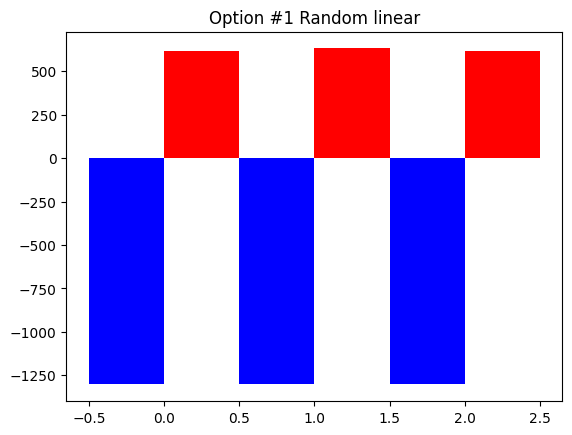

In [422]:
x = np.arange(len(bar_mean1_rand_linear))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #1 Random linear')
rect1 = plt.bar(x-w/2,bar_mean1_rand_linear,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds1_rand_linear,w,color = 'r')
plt.show()

[0 1 2]


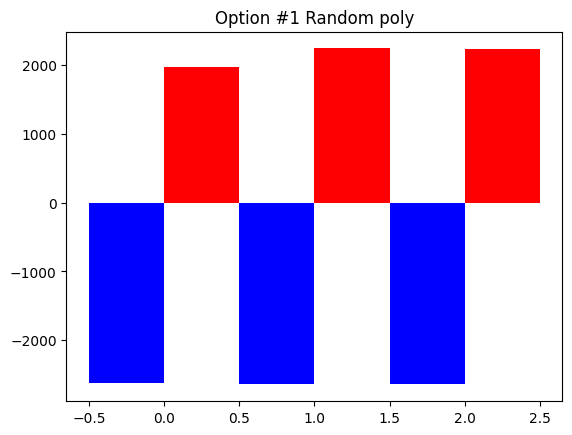

In [423]:
x = np.arange(len(bar_mean1_rand_poly))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #1 Random poly')
rect1 = plt.bar(x-w/2,bar_mean1_rand_poly,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds1_rand_poly,w,color = 'r')
plt.show()

[0 1 2 3]


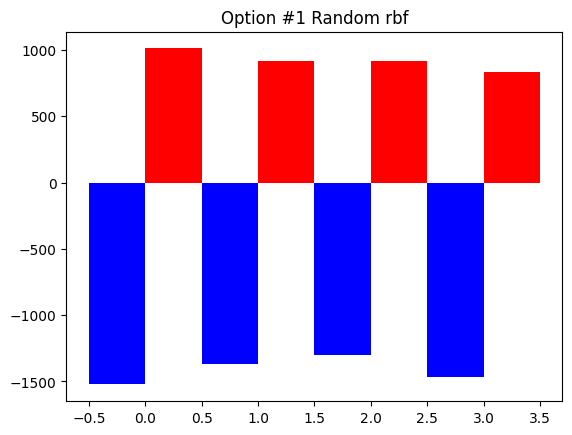

In [424]:
x = np.arange(len(bar_mean1_rand_rbf))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #1 Random rbf')
rect1 = plt.bar(x-w/2,bar_mean1_rand_rbf,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds1_rand_rbf,w,color = 'r')
plt.show()

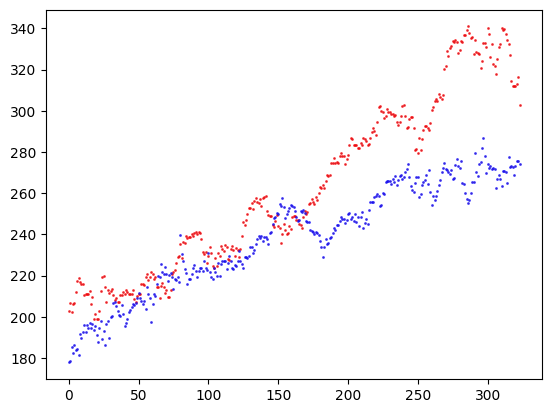

In [425]:
plt.scatter(np.arange(len(Y_test1)),Y_test1, edgecolors='r',alpha=0.75,s=1)
plt.scatter(np.arange(len(bestmodelbtw_pred)),bestmodelbtw_pred, edgecolors='b',alpha=0.75,s=1)
plt.show()

In [426]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR
    grid_rand = RandomizedSearchCV(estimator=model, n_jobs = 1,verbose = 10,cv = 3,scoring = 'neg_mean_squared_error',param_distributions = params)
    grid_rand_result = grid_rand.fit(X_train2, y_train2)


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklear

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START fit_intercept=True, normalize=True..........................
[CV 1/3; 1/4] END fit_intercept=True, normalize=True;, score=-206.623 total time=   0.0s
[CV 2/3; 1/4] START fit_intercept=True, normalize=True..........................
[CV 2/3; 1/4] END fit_intercept=True, normalize=True;, score=-241.136 total time=   0.0s
[CV 3/3; 1/4] START fit_intercept=True, normalize=True..........................
[CV 3/3; 1/4] END fit_intercept=True, normalize=True;, score=-219.019 total time=   0.0s
[CV 1/3; 2/4] START fit_intercept=True, normalize=False.........................
[CV 1/3; 2/4] END fit_intercept=True, normalize=False;, score=-206.623 total time=   0.0s
[CV 2/3; 2/4] START fit_intercept=True, normalize=False.........................
[CV 2/3; 2/4] END fit_intercept=True, normalize=False;, score=-241.136 total time=   0.0s
[CV 3/3; 2/4] START fit_intercept=True, normalize=False.........................
[CV 3/3

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/3; 1/10] END C=0.1, degree=2, epsilon=0.325, gamma=0.01, kernel=rbf;, score=-5632.785 total time=   0.0s
[CV 2/3; 1/10] START C=0.1, degree=2, epsilon=0.325, gamma=0.01, kernel=rbf.....
[CV 2/3; 1/10] END C=0.1, degree=2, epsilon=0.325, gamma=0.01, kernel=rbf;, score=-5766.361 total time=   0.0s
[CV 3/3; 1/10] START C=0.1, degree=2, epsilon=0.325, gamma=0.01, kernel=rbf.....
[CV 3/3; 1/10] END C=0.1, degree=2, epsilon=0.325, gamma=0.01, kernel=rbf;, score=-6197.294 total time=   0.0s
[CV 1/3; 2/10] START C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly.....
[CV 1/3; 2/10] END C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly;, score=-5763.653 total time=   0.0s
[CV 2/3; 2/10] START C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly.....
[CV 2/3; 2/10] END C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly;, score=-5871.432 total time=   0.0s
[CV 3/3; 2/10] START C=0.1, degree=3, epsilon=0.55, gamma=0.01, kernel=poly.....
[CV 3/3; 2/10] END C=0.1, degree=3, epsi

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

[CV 1/3; 3/10] END C=0.1, degree=2, epsilon=1.0, gamma=0.0325, kernel=poly;, score=-5732.969 total time=   0.0s
[CV 2/3; 3/10] START C=0.1, degree=2, epsilon=1.0, gamma=0.0325, kernel=poly....
[CV 2/3; 3/10] END C=0.1, degree=2, epsilon=1.0, gamma=0.0325, kernel=poly;, score=-5833.776 total time=   0.0s
[CV 3/3; 3/10] START C=0.1, degree=2, epsilon=1.0, gamma=0.0325, kernel=poly....
[CV 3/3; 3/10] END C=0.1, degree=2, epsilon=1.0, gamma=0.0325, kernel=poly;, score=-6236.943 total time=   0.0s
[CV 1/3; 4/10] START C=150.0, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=rbf
[CV 1/3; 4/10] END C=150.0, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=rbf;, score=-66.937 total time=   0.0s
[CV 2/3; 4/10] START C=150.0, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=rbf


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

[CV 2/3; 4/10] END C=150.0, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=rbf;, score=-63.177 total time=   0.0s
[CV 3/3; 4/10] START C=150.0, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=rbf
[CV 3/3; 4/10] END C=150.0, degree=3, epsilon=0.775, gamma=0.05500000000000001, kernel=rbf;, score=-77.933 total time=   0.0s
[CV 1/3; 5/10] START C=0.1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 1/3; 5/10] END C=0.1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5744.278 total time=   0.0s
[CV 2/3; 5/10] START C=0.1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 2/3; 5/10] END C=0.1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-5862.291 total time=   0.0s
[CV 3/3; 5/10] START C=0.1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly......
[CV 3/3; 5/10] END C=0.1, degree=2, epsilon=0.1, gamma=0.01, kernel=poly;, score=-6315.728 total time=   0.0s
[CV 1/3; 6/10] START C=37.575, degree=2, epsilon=0.55, gamma=0.0325, kernel=rbf.


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 1/3; 6/10] END C=37.575, degree=2, epsilon=0.55, gamma=0.0325, kernel=rbf;, score=-134.153 total time=   0.0s
[CV 2/3; 6/10] START C=37.575, degree=2, epsilon=0.55, gamma=0.0325, kernel=rbf.
[CV 2/3; 6/10] END C=37.575, degree=2, epsilon=0.55, gamma=0.0325, kernel=rbf;, score=-142.996 total time=   0.0s
[CV 3/3; 6/10] START C=37.575, degree=2, epsilon=0.55, gamma=0.0325, kernel=rbf.
[CV 3/3; 6/10] END C=37.575, degree=2, epsilon=0.55, gamma=0.0325, kernel=rbf;, score=-141.997 total time=   0.0s
[CV 1/3; 7/10] START C=75.05, degree=2, epsilon=0.775, gamma=0.0775, kernel=poly
[CV 1/3; 7/10] END C=75.05, degree=2, epsilon=0.775, gamma=0.0775, kernel=poly;, score=-588.086 total time=   0.0s
[CV 2/3; 7/10] START C=75.05, degree=2, epsilon=0.775, gamma=0.0775, kernel=poly


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 2/3; 7/10] END C=75.05, degree=2, epsilon=0.775, gamma=0.0775, kernel=poly;, score=-642.876 total time=   0.0s
[CV 3/3; 7/10] START C=75.05, degree=2, epsilon=0.775, gamma=0.0775, kernel=poly
[CV 3/3; 7/10] END C=75.05, degree=2, epsilon=0.775, gamma=0.0775, kernel=poly;, score=-535.672 total time=   0.0s
[CV 1/3; 8/10] START C=112.525, degree=3, epsilon=0.325, gamma=0.1, kernel=rbf..
[CV 1/3; 8/10] END C=112.525, degree=3, epsilon=0.325, gamma=0.1, kernel=rbf;, score=-51.527 total time=   0.0s
[CV 2/3; 8/10] START C=112.525, degree=3, epsilon=0.325, gamma=0.1, kernel=rbf..
[CV 2/3; 8/10] END C=112.525, degree=3, epsilon=0.325, gamma=0.1, kernel=rbf;, score=-57.543 total time=   0.0s
[CV 3/3; 8/10] START C=112.525, degree=3, epsilon=0.325, gamma=0.1, kernel=rbf..


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 3/3; 8/10] END C=112.525, degree=3, epsilon=0.325, gamma=0.1, kernel=rbf;, score=-63.099 total time=   0.0s
[CV 1/3; 9/10] START C=150.0, degree=2, epsilon=1.0, gamma=0.05500000000000001, kernel=poly
[CV 1/3; 9/10] END C=150.0, degree=2, epsilon=1.0, gamma=0.05500000000000001, kernel=poly;, score=-583.586 total time=   0.0s
[CV 2/3; 9/10] START C=150.0, degree=2, epsilon=1.0, gamma=0.05500000000000001, kernel=poly
[CV 2/3; 9/10] END C=150.0, degree=2, epsilon=1.0, gamma=0.05500000000000001, kernel=poly;, score=-642.086 total time=   0.0s
[CV 3/3; 9/10] START C=150.0, degree=2, epsilon=1.0, gamma=0.05500000000000001, kernel=poly
[CV 3/3; 9/10] END C=150.0, degree=2, epsilon=1.0, gamma=0.05500000000000001, kernel=poly;, score=-536.379 total time=   0.0s
[CV 1/3; 10/10] START C=37.575, degree=3, epsilon=0.775, gamma=0.01, kernel=poly
[CV 1/3; 10/10] END C=37.575, degree=3, epsilon=0.775, gamma=0.01, kernel=poly;, score=-5498.572 total time=   0.0s
[CV 2/3; 10/10] START C=37.575, degre

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names wit

[CV 3/3; 10/10] END C=37.575, degree=3, epsilon=0.775, gamma=0.01, kernel=poly;, score=-5978.371 total time=   0.0s


In [427]:
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.325, 'degree': 3, 'C': 112.525}
Best score:  -57.38972152131788


In [428]:
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']
bestmodelbtw = SVR(kernel = grid_rand_result.best_params_['kernel'], C = grid_rand_result.best_params_['C'], degree= grid_rand_result.best_params_['degree'], epsilon = grid_rand_result.best_params_['epsilon'], gamma = grid_rand_result.best_params_['gamma'])
bestmodelbtw_pred = bestmodelbtw.fit(X_train2,y_train2).predict(X_test2)


bar_mean2_rand_linear = []
bar_stds2_rand_linear = []
bar_mean2_rand_poly = []
bar_stds2_rand_poly = []
bar_mean2_rand_rbf = []
bar_stds2_rand_rbf = []
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    if param['kernel'] == 'linear':
        bar_mean2_rand_linear.append(mean)
        bar_stds2_rand_linear.append(stdev)
    elif param['kernel'] == 'poly': 
        bar_mean2_rand_poly.append(mean)
        bar_stds2_rand_poly.append(stdev)
    else:
        bar_mean2_rand_rbf.append(mean)
        bar_stds2_rand_rbf.append(stdev)

-5865.479920 (240.881473) with: {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.325, 'degree': 2, 'C': 0.1}
-5980.667581 (234.852346) with: {'kernel': 'poly', 'gamma': 0.01, 'epsilon': 0.55, 'degree': 3, 'C': 0.1}
-5934.562719 (217.739932) with: {'kernel': 'poly', 'gamma': 0.0325, 'epsilon': 1.0, 'degree': 2, 'C': 0.1}
-69.349275 (6.260968) with: {'kernel': 'rbf', 'gamma': 0.05500000000000001, 'epsilon': 0.775, 'degree': 3, 'C': 150.0}
-5974.098706 (246.325775) with: {'kernel': 'poly', 'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, 'C': 0.1}
-139.715524 (3.954500) with: {'kernel': 'rbf', 'gamma': 0.0325, 'epsilon': 0.55, 'degree': 2, 'C': 37.575}
-588.877939 (43.769772) with: {'kernel': 'poly', 'gamma': 0.0775, 'epsilon': 0.775, 'degree': 2, 'C': 75.05}
-57.389722 (4.725372) with: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.325, 'degree': 3, 'C': 112.525}
-587.350421 (43.237015) with: {'kernel': 'poly', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 2, 'C': 150.0}
-5675.430224 (21

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


[]


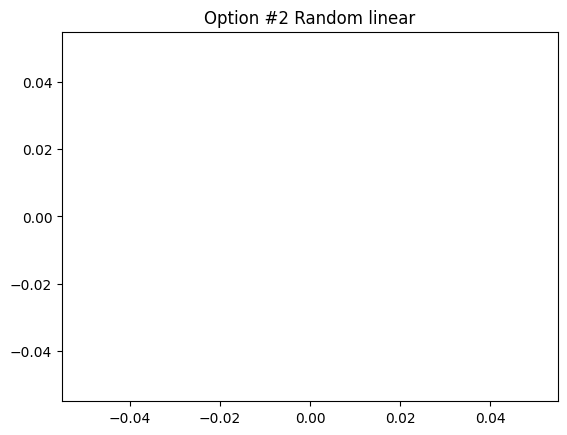

In [429]:
x = np.arange(len(bar_mean2_rand_linear))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #2 Random linear')
rect1 = plt.bar(x-w/2,bar_mean2_rand_linear,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds2_rand_linear,w,color = 'r')
plt.show()

[0 1 2 3 4 5]


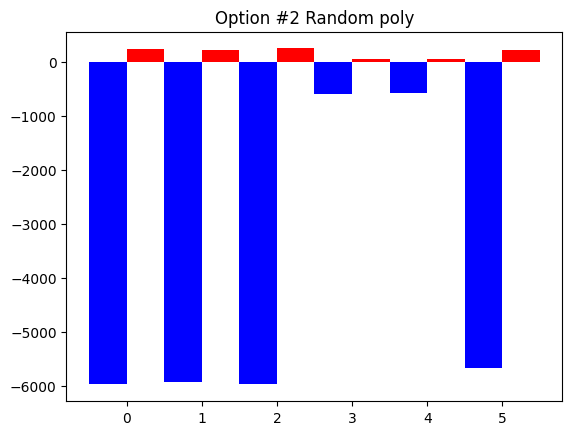

In [430]:
x = np.arange(len(bar_mean2_rand_poly))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #2 Random poly')
rect1 = plt.bar(x-w/2,bar_mean2_rand_poly,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds2_rand_poly,w,color = 'r')
plt.show()

[0 1 2 3]


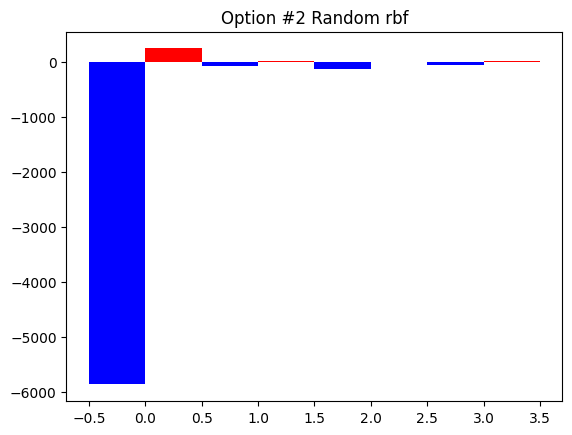

In [431]:
x = np.arange(len(bar_mean2_rand_rbf))
print(x)
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Option #2 Random rbf')
rect1 = plt.bar(x-w/2,bar_mean2_rand_rbf,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_stds2_rand_rbf,w,color = 'r')
plt.show()

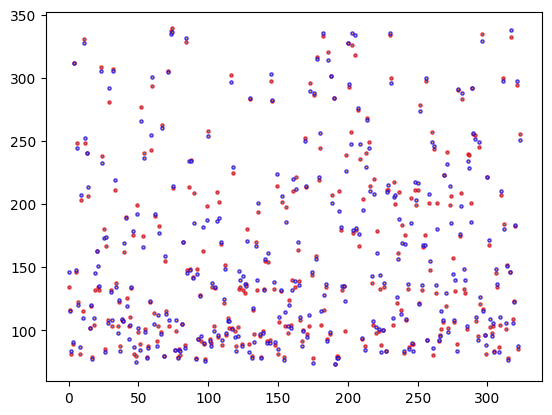

In [432]:
plt.scatter(np.arange(len(y_test2)),y_test2, edgecolors='r',alpha=0.75,s=5)
plt.scatter(np.arange(len(bestmodelbtw_pred)),bestmodelbtw_pred, edgecolors='b',alpha=0.75,s=5)
plt.show()